In [1]:
import pysam
import os
import sys
from sys import getsizeof
import time

directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_total_coverage_for_contig_at_position,\
print_read_info, update_coverage_array, get_read_information, get_hamming_distance, remove_softclipped_bases,find

from utils import get_intervals, index_bam, write_rows_to_info_file, write_header_to_bam, \
write_read_to_bam_file, remove_file_if_exists, make_folder

import os, psutil


# ~~~~~~~~~~~~~~~~~~
# Multi-processing enabled
# ~~~~~~~~~~~~~~~~~~

# An example on a bam for 1500 cell barcodes (group0, group1, group2, group3, group4, group5, group6, group7 group8, group9, group10, group11 split from the original bam)

### Should be about 1500*30,000 = 45 million reads

#### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
bampath = '/projects/ps-yeolab3/ekofman/sailor2/data/groups_0_1_2_3_4_5_6_7_8_9_10_11_merged.bam'
samfile = pysam.AlignmentFile(bampath, "rb")

In [3]:
samfile_header = str(samfile.header)

In [4]:
getsizeof(samfile_header)/1000

19338.323

# Helper functions

In [5]:
def find_edits(bampath, contig, split_index, start, end, output_folder, verbose=False):
    time_reporting = {}
    start_time = time.perf_counter()
    
    samfile = pysam.AlignmentFile(bampath, "rb")
        
    counts = defaultdict(lambda:defaultdict(lambda:0))
    total_reads = 0
    
    bam_handles_for_barcodes = {}
    read_lists_for_barcodes = defaultdict(lambda:[])
    
    reads_for_contig = samfile.fetch(contig, start, end, multiple_iterators=True)

    output_file = '{}/{}_{}_{}_{}_edit_info.tsv'.format(edit_info_subfolder, contig, split_index, start, end)
    remove_file_if_exists(output_file)

    with open(output_file, 'w') as f:        
        write_header_to_bam(f)

        for i, read in enumerate(reads_for_contig):
            total_reads += 1
            
            if total_reads % 1000 == 0:
                time_reporting[total_reads] = time.perf_counter() - start_time

            barcode = read.get_tag("CB")
            barcodes[contig][barcode] += 1

            verbose = False
            
            # This is to ID the weird read with Ns
            if 'AAACCCAAGAACTTCC-1' == barcode and split_index == '005' and contig == '17':
                if read.query_name == 'A01535:287:H3JJHDSX7:1:2176:29188:6324':
                    verbose = True
            
            try:
                error_code, list_of_rows, num_edits_of_each_type = get_read_information(read, contig, verbose=verbose)
            except Exception as e:
                print("Failed on\n{}".format(read.to_string()))
                break
                
            if error_code:
                counts[contig][error_code] += 1
            else:
                counts[contig][EDITED_CODE] += 1
                write_rows_to_info_file(list_of_rows, f)
            
            # Store each read using its string representation
            read_as_string = read.to_string()
            
            if 'AAACCCAAGAACTTCC-1' == barcode and split_index == '005':
                if read.query_name == 'A01535:287:H3JJHDSX7:1:2176:29188:6324':
                    print("\n\n~~~ Found read, is {}\nSplit index is {}; edit types is {}; \n{}~~~".format(read_as_string, 
                                                                                                     split_index,
                                                                                                     num_edits_of_each_type,
                                                                                                     list_of_rows
                                                                                                    ))
                    print("Read as string:\n{}".format(read_as_string))
                    
            read_lists_for_barcodes[barcode].append(read_as_string)
            
    
    # Add all reads to dictionary for contig and barcode, in their string representation
    num_barcodes = 0
    total_bams = len(read_lists_for_barcodes)
    
    
    barcode_to_concatted_reads = {}
    for barcode, read_list in read_lists_for_barcodes.items():
        num_barcodes += 1
        if num_barcodes % 100 == 0:
            #print('{}/{} processed'.format(num_barcodes, total_bams))
            pass
        # Concatenate the string representations of all reads for each bam-contig combination
        all_reads_concatted = '\n'.join(read_list)
            
        # Save this concatenated block of text to dictionary
        barcode_to_concatted_reads[barcode] = all_reads_concatted
        
    time_reporting[total_reads] = time.perf_counter() - start_time
    
    samfile.close()
    
    return barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting


def find_edits_and_split_bams(bampath, contig, split_index, start, end, output_folder, verbose=False):
    barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting = find_edits(bampath, contig, split_index,
                                                                         start, end, output_folder, verbose=verbose)    
    return barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting
    
def find_edits_and_split_bams_wrapper(parameters):
    try:
        start_time = time.perf_counter()
        bampath, contig, split_index, start, end, output_folder, verbose = parameters
        label = '{}({}):{}-{}'.format(contig, split_index, start, end)

        #print("{} ({}):{}-{}\tfind_edits_and_split_bams".format(contig, split_index, start, end))
        barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting = find_edits_and_split_bams(bampath, contig, split_index, start, end, output_folder, verbose=False)
        barcodes_df = pd.DataFrame.from_dict(barcodes)
        counts_df = pd.DataFrame.from_dict(counts)
        time_df = pd.DataFrame.from_dict(time_reporting, orient='index')
        barcode_to_concatted_reads_df = pd.DataFrame.from_dict(barcode_to_concatted_reads, orient='index')
        
        total_time = time.perf_counter() - start_time
        return barcode_to_concatted_reads_df, total_reads, barcodes_df, label, counts_df, time_df, total_time
    except Exception as e:
        print('Contig {}: {}'.format(label, e))
        return 0, pd.DataFrame(), label, pd.DataFrame()

# Go through every read and identify all edits

In [7]:
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm

start_time = time.perf_counter()

print("CPU count: {}".format(multiprocessing.cpu_count()))

output_folder = '/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger'

contig_lengths_dict = get_contig_lengths_dict(samfile)

# Print info?
verbose = False 
EDITED_CODE = 'edited'

# How many subcontigs to split each contig into to leverage multi-processing
num_intervals = 16

num_reads_to_coverage_dict_kb = {}
num_reads_to_seconds = {}


start_time = time.perf_counter()
total_seconds_for_reads = {0: 1}

barcodes = defaultdict(lambda:defaultdict(lambda:0))

jobs = []
for contig in contig_lengths_dict.keys():
    # Skip useless contigs
    if len(contig) > 5 or contig == 'Stamp':# or contig != '17':
        continue
        
    print("Contig {}".format(contig))
    contig_length = contig_lengths_dict.get(contig)
    intervals_for_contig = get_intervals(contig, contig_lengths_dict, num_intervals)
    
    # Make subfolder in which to information about edits
    edit_info_subfolder = '{}/edit_info'.format(output_folder)
    make_folder(edit_info_subfolder)
        
    # Set up for pool
    for split_index, interval in enumerate(intervals_for_contig):
        split_index = str(split_index).zfill(3)
        parameters = [bampath, contig, split_index, interval[0], interval[1], output_folder, verbose]
        jobs.append(parameters)
    
print("{} total jobs".format(len(jobs)))

# Pooling
results = []
overall_total_reads = 0
with Pool(processes=16) as p:
    max_ = len(jobs)
    with tqdm(total=max_) as pbar:
        for _ in p.imap_unordered(find_edits_and_split_bams_wrapper, jobs):
            pbar.update()
            results.append(_)
            
            total_reads = _[1]
            total_time = time.perf_counter() - start_time
            
            overall_total_reads += total_reads
            print('total reads overall', overall_total_reads)

            total_seconds_for_reads[overall_total_reads] = total_time

overall_time = time.perf_counter() - start_time 


CPU count: 36
Contig 1
Contig 10
Contig 11
Contig 12
Contig 13
Contig 14
Contig 15
Contig 16
Contig 17
Contig 18
Contig 19
Contig 2
Contig 3
Contig 4
Contig 5
Contig 6
Contig 7
Contig 8
Contig 9
Contig MT
Contig X
Contig Y
352 total jobs


  0%|          | 1/352 [00:00<05:12,  1.12it/s]

total reads overall 10754


  1%|          | 2/352 [00:01<03:02,  1.91it/s]

total reads overall 37656
total reads overall 62170


  1%|▏         | 5/352 [00:01<01:23,  4.17it/s]

total reads overall 79556
total reads overall 108484


  2%|▏         | 7/352 [00:01<00:52,  6.56it/s]

total reads overall 134767
total reads overall 149088
total reads overall 184504


  3%|▎         | 11/352 [00:02<00:41,  8.18it/s]

total reads overall 224289
total reads overall 262417
total reads overall 284620
total reads overall 323492
total reads overall 376662


  4%|▍         | 15/352 [00:02<00:26, 12.51it/s]

total reads overall 394256
total reads overall 448581
total reads overall 463508
total reads overall 493101


  5%|▌         | 18/352 [00:02<00:32, 10.36it/s]

total reads overall 509164
total reads overall 556492


  7%|▋         | 24/352 [00:03<00:23, 13.68it/s]

total reads overall 628589
total reads overall 651715
total reads overall 653684
total reads overall 675322
total reads overall 694180
total reads overall 718523


  7%|▋         | 26/352 [00:03<00:23, 14.01it/s]

total reads overall 781868
total reads overall 811456


  8%|▊         | 28/352 [00:03<00:32,  9.84it/s]

total reads overall 822983
total reads overall 849534


  9%|▉         | 32/352 [00:04<00:40,  7.91it/s]

total reads overall 876974
total reads overall 911506
total reads overall 957781
total reads overall 1015331


 10%|▉         | 35/352 [00:04<00:51,  6.10it/s]

total reads overall 1060305
total reads overall 1129284


 11%|█         | 38/352 [00:05<00:37,  8.44it/s]

total reads overall 1173750
total reads overall 1217715
total reads overall 1265636
total reads overall 1367866


 12%|█▏        | 42/352 [00:05<00:28, 10.76it/s]

total reads overall 1428166
total reads overall 1450982
total reads overall 1465134


 13%|█▎        | 46/352 [00:05<00:22, 13.52it/s]

total reads overall 1530762
total reads overall 1547556
total reads overall 1584352
total reads overall 1628100


 14%|█▍        | 49/352 [00:05<00:20, 14.88it/s]

total reads overall 1638697
total reads overall 1657522
total reads overall 1674511
total reads overall 1694111


 14%|█▍        | 51/352 [00:06<00:24, 12.37it/s]

total reads overall 1699963
total reads overall 1705234
total reads overall 1719508


 16%|█▋        | 58/352 [00:06<00:20, 14.52it/s]

total reads overall 1810796
total reads overall 1886923
total reads overall 1910322
total reads overall 1932161
total reads overall 1946503
total reads overall 1959628


 18%|█▊        | 62/352 [00:07<00:27, 10.42it/s]

total reads overall 1981799
total reads overall 1997887
total reads overall 2035021
total reads overall 2076535


 19%|█▉        | 66/352 [00:07<00:20, 13.77it/s]

total reads overall 2091108
total reads overall 2108489
total reads overall 2128261
total reads overall 2128508


 20%|█▉        | 70/352 [00:07<00:23, 12.03it/s]

total reads overall 2155464
total reads overall 2167109
total reads overall 2190320


 20%|██        | 72/352 [00:07<00:27, 10.05it/s]

total reads overall 2245552
total reads overall 2343636


 21%|██▏       | 75/352 [00:08<00:22, 12.11it/s]

total reads overall 2361192
total reads overall 2438926
total reads overall 2461452


 22%|██▏       | 77/352 [00:08<00:25, 11.00it/s]

total reads overall 2476893
total reads overall 2527784
total reads overall 2560919
total reads overall 2578524
total reads overall 2600277


 24%|██▎       | 83/352 [00:08<00:17, 15.04it/s]

total reads overall 2637682
total reads overall 2661072
total reads overall 2711842


 25%|██▍       | 87/352 [00:08<00:15, 16.80it/s]

total reads overall 2809105
total reads overall 2820417
total reads overall 2847196
total reads overall 2853941
total reads overall 2857182


 25%|██▌       | 89/352 [00:09<00:18, 14.32it/s]

total reads overall 2874152
total reads overall 2891462


 26%|██▋       | 93/352 [00:09<00:20, 12.77it/s]

total reads overall 2909057
total reads overall 2920113
total reads overall 2939004
total reads overall 2947518
total reads overall 2971897


 28%|██▊       | 99/352 [00:09<00:13, 18.38it/s]

total reads overall 3011239
total reads overall 3028322
total reads overall 3041823
total reads overall 3057270


 30%|██▉       | 105/352 [00:09<00:12, 20.56it/s]

total reads overall 3101338
total reads overall 3131673
total reads overall 3171991
total reads overall 3217553
total reads overall 3230852
total reads overall 3277713
total reads overall 3290803
total reads overall 3308474


 31%|███       | 108/352 [00:10<00:21, 11.30it/s]

total reads overall 3329813
total reads overall 3340650


 31%|███▏      | 110/352 [00:10<00:24,  9.84it/s]

total reads overall 3347671
total reads overall 3371674
total reads overall 3377791


 33%|███▎      | 117/352 [00:11<00:15, 14.91it/s]

total reads overall 3392462
total reads overall 3397020
total reads overall 3431471
total reads overall 3458461
total reads overall 3495018


 34%|███▍      | 120/352 [00:11<00:15, 14.69it/s]

total reads overall 3501250
total reads overall 3548325
total reads overall 3580611
total reads overall 3587512


 35%|███▍      | 122/352 [00:11<00:15, 14.65it/s]

total reads overall 3638903


 36%|███▌      | 126/352 [00:11<00:18, 12.35it/s]

total reads overall 3647050
total reads overall 3664687
total reads overall 3729913
total reads overall 3756538


 37%|███▋      | 130/352 [00:12<00:17, 12.37it/s]

total reads overall 3830366
total reads overall 3837868
total reads overall 3884620
total reads overall 3907592


 38%|███▊      | 132/352 [00:12<00:18, 11.82it/s]

total reads overall 3919178
total reads overall 3923291
total reads overall 3952057
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Read ID: A01535:287:H3JJHDSX7:1:2176:29188:6324
----------------------------
MD tag: 89C11
CIGAR string 4M102N92M90N5M
Reference seq: AAGGCCCCAAAAGTGGCGCAGCCCTCTATGGGCTCGAATTTTCTTCAGCCTCTCCAGGTCCTCACGCAGCTTGTTGTCTAGACCGTTGGCCAGAACCTGGC
Aligned seq: AAGGCCCCAAAAGTGGCGCAGCCCTCTATGGGCTCGAATTTTCTTCAGCCTCTCCAGGTCCTCACGCAGCTTGTTGTCTAGACCGTTGGTCAGAACCTGGC
CIGAR tuples before clipping (if needed):
 [(0, 4), (3, 102), (0, 92), (3, 90), (0, 5)]
Aligned sequence before clipping (if needed):
 AAGGCCCCAAAAGTGGCGCAGCCCTCTATGGGCTCGAATTTTCTTCAGCCTCTCCAGGTCCTCACGCAGCTTGTTGTCTAGACCGTTGGTCAGAACCTGGC


 38%|███▊      | 134/352 [00:12<00:19, 11.24it/s]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CIGAR tuples after clipping (if needed):
 [(0, 4), (3, 102), (0, 92), (3, 90), (0, 5)]


 39%|███▉      | 139/352 [00:12<00:11, 17.94it/s]

Aligned sequence after clipping (if needed):
 AAGGCCCCAAAAGTGGCGCAGCCCTCTATGGGCTCGAATTTTCTTCAGCCTCTCCAGGTCCTCACGCAGCTTGTTGTCTAGACCGTTGGTCAGAACCTGGC
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
total reads overall 3968821
total reads overall 3995771
total reads overall 4045882
total reads overall 4079252
total reads overall 4082906
total reads overall 4122720
['89', '11']
[89, 101]
Indicated reference seq:
 aaggccccaaaagtggcgcagccctctatgggctcgaattttcttcagcctctccaggtcctcacgcagcttgttgtctagaccgttggCcagaacctggc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fixed reference seq:
 aaggnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnccccaaaagtggcgcagccctctatgggctcgaattttcttcagcctctccaggtcctcacgcagcttgttgtctagaccgttggCcagaacnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnctggc
Fixed aligned seq:
 AAGGnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnCCCCAAAAGTG

 40%|████      | 142/352 [00:13<00:15, 13.79it/s]

Read as string:
A01535:287:H3JJHDSX7:1:2176:29188:6324	16	17	33952115	255	4M102N92M90N5M	*	0	0	AAGGCCCCAAAAGTGGCGCAGCCCTCTATGGGCTCGAATTTTCTTCAGCCTCTCCAGGTCCTCACGCAGCTTGTTGTCTAGACCGTTGGTCAGAACCTGGC	:FFFFFFF:FFFFFFFFF,FFFFFFFF,FFFF,FFF::FF:FF:FFFFFFFFFFFFFFFFFFF,FFFFFFFFF,FFFFFFFFFFFFFFFFFFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:101	nM:i:1	TX:Z:ENSMUST00000008812,+383,101M;ENSMUST00000172799,+935,101M;ENSMUST00000174745,+319,101M;ENSMUST00000174758,+282,101M	GX:Z:ENSMUSG00000008668	GN:Z:Rps18	fx:Z:ENSMUSG00000008668	RE:A:E	xf:i:25	CR:Z:AAACCCAAGAACTTCC	CY:Z:FF:F,FFFFFFFF:FF	CB:Z:AAACCCAAGAACTTCC-1	UR:Z:CGCCCCTGCGCA	UY:Z:FFFFFFFF:,FF	UB:Z:CGCCCCTGCTCA	NM:i:1	MD:Z:89C11	RG:Z:ms_hippo_stamp_EIF4A_batch2:0:1:H3JJHDSX7:1-32F01FC
total reads overall 4140486
total reads overall 4147690
total reads overall 4160545
total reads overall 4170481
total reads overall 4183697


 42%|████▏     | 147/352 [00:13<00:13, 15.03it/s]

total reads overall 4202269
total reads overall 4217379
total reads overall 4221688
total reads overall 4224710


 42%|████▏     | 149/352 [00:13<00:17, 11.85it/s]

total reads overall 4261391
total reads overall 4273850


 44%|████▍     | 154/352 [00:13<00:15, 13.16it/s]

total reads overall 4278541
total reads overall 4309119
total reads overall 4328578
total reads overall 4349788


 45%|████▍     | 158/352 [00:14<00:13, 14.83it/s]

total reads overall 4414123
total reads overall 4445220
total reads overall 4453954
total reads overall 4463763


 45%|████▌     | 160/352 [00:14<00:14, 13.13it/s]

total reads overall 4490274
total reads overall 4500487


 47%|████▋     | 165/352 [00:14<00:10, 17.51it/s]

total reads overall 4590745
total reads overall 4604771
total reads overall 4616877
total reads overall 4627761
total reads overall 4730269
total reads overall 4752958
total reads overall 4758440


 49%|████▊     | 171/352 [00:14<00:10, 17.60it/s]

total reads overall 4808622
total reads overall 4825665
total reads overall 4835846
total reads overall 4847629
total reads overall 4872041


 49%|████▉     | 173/352 [00:15<00:17, 10.39it/s]

total reads overall 4936776
total reads overall 4959309


 50%|████▉     | 175/352 [00:15<00:20,  8.47it/s]

total reads overall 4977284
total reads overall 5012596


 51%|█████     | 179/352 [00:16<00:27,  6.39it/s]

total reads overall 5042324
total reads overall 5093009
total reads overall 5127395
total reads overall 5163066


 51%|█████▏    | 181/352 [00:17<00:30,  5.61it/s]

total reads overall 5204857
total reads overall 5223686
total reads overall 5233136


 53%|█████▎    | 186/352 [00:17<00:21,  7.64it/s]

total reads overall 5238620
total reads overall 5286306
total reads overall 5344504
total reads overall 5390187


 54%|█████▍    | 190/352 [00:18<00:21,  7.46it/s]

total reads overall 5499953
total reads overall 5579441
total reads overall 5636269


 55%|█████▌    | 194/352 [00:18<00:13, 11.53it/s]

total reads overall 5664078
total reads overall 5675369
total reads overall 5738625
total reads overall 5756055


 56%|█████▌    | 196/352 [00:18<00:13, 11.42it/s]

total reads overall 5795084
total reads overall 5809436
total reads overall 5846534


 56%|█████▋    | 198/352 [00:18<00:15, 10.14it/s]

total reads overall 5883491
total reads overall 5894381


 57%|█████▋    | 202/352 [00:19<00:15,  9.52it/s]

total reads overall 6007896
total reads overall 6021336
total reads overall 6040849


 59%|█████▊    | 206/352 [00:19<00:12, 11.88it/s]

total reads overall 6057069
total reads overall 6070315
total reads overall 6097947
total reads overall 6124219
total reads overall 6142082


 60%|█████▉    | 210/352 [00:19<00:12, 11.49it/s]

total reads overall 6200704
total reads overall 6211052
total reads overall 6274253


 60%|██████    | 212/352 [00:20<00:17,  8.03it/s]

total reads overall 6312466
total reads overall 6388275
total reads overall 6417798


 61%|██████    | 214/352 [00:20<00:17,  7.69it/s]

total reads overall 6470067
total reads overall 6491945


 62%|██████▏   | 219/352 [00:20<00:12, 10.51it/s]

total reads overall 6540051
total reads overall 6551791
total reads overall 6570081
total reads overall 6587129


 63%|██████▎   | 221/352 [00:21<00:18,  6.95it/s]

total reads overall 6633550
total reads overall 6680957
total reads overall 6703027


 64%|██████▎   | 224/352 [00:21<00:13,  9.25it/s]

total reads overall 6727155
total reads overall 6763260


 64%|██████▍   | 226/352 [00:21<00:15,  8.39it/s]

total reads overall 6782382
total reads overall 6803874
total reads overall 6833068


 65%|██████▌   | 230/352 [00:22<00:18,  6.54it/s]

total reads overall 6927732
total reads overall 6992632
total reads overall 7065062
total reads overall 7109122
total reads overall 7170086


 66%|██████▌   | 233/352 [00:22<00:12,  9.23it/s]

total reads overall 7205633
total reads overall 7222021


 67%|██████▋   | 235/352 [00:23<00:17,  6.58it/s]

total reads overall 7245536
total reads overall 7302384


 68%|██████▊   | 239/352 [00:23<00:13,  8.10it/s]

total reads overall 7349993
total reads overall 7372116
total reads overall 7433757


 68%|██████▊   | 241/352 [00:23<00:11,  9.38it/s]

total reads overall 7459382
total reads overall 7481174
total reads overall 7506937


 69%|██████▉   | 243/352 [00:24<00:11,  9.33it/s]

total reads overall 7539662
total reads overall 7576969
total reads overall 7656476


 70%|██████▉   | 246/352 [00:24<00:11,  9.28it/s]

total reads overall 7672748


 70%|███████   | 248/352 [00:24<00:13,  7.55it/s]

total reads overall 8075234
total reads overall 8102455
total reads overall 8151314
total reads overall 8169327
total reads overall 8199779


 72%|███████▏  | 254/352 [00:25<00:10,  9.61it/s]

total reads overall 8249422
total reads overall 8289085
total reads overall 8340394


 73%|███████▎  | 256/352 [00:25<00:10,  8.95it/s]

total reads overall 8370511
total reads overall 8412349


 73%|███████▎  | 258/352 [00:25<00:10,  8.69it/s]

total reads overall 8454854
total reads overall 8479306


 74%|███████▍  | 260/352 [00:26<00:12,  7.63it/s]

total reads overall 8502825
total reads overall 8570430
total reads overall 8580205


 75%|███████▌  | 264/352 [00:26<00:09,  8.85it/s]

total reads overall 8610120
total reads overall 8642164
total reads overall 8705975


 76%|███████▌  | 266/352 [00:26<00:09,  9.02it/s]

total reads overall 8767449
total reads overall 8862311
total reads overall 8895197
total reads overall 8911807


 76%|███████▋  | 269/352 [00:26<00:07, 11.75it/s]

total reads overall 8991435
total reads overall 9009529


 77%|███████▋  | 271/352 [00:27<00:07, 11.06it/s]

total reads overall 9025027
total reads overall 9062291


 78%|███████▊  | 276/352 [00:27<00:05, 13.52it/s]

total reads overall 9088216
total reads overall 9096030
total reads overall 9112913
total reads overall 9157884
total reads overall 9184585


 79%|███████▉  | 278/352 [00:27<00:05, 13.15it/s]

total reads overall 9251401
total reads overall 9308586


 80%|███████▉  | 280/352 [00:27<00:06, 11.65it/s]

total reads overall 9372623
total reads overall 9387247


 81%|████████  | 284/352 [00:28<00:08,  8.11it/s]

total reads overall 9409071
total reads overall 9438270
total reads overall 9490248


 81%|████████▏ | 286/352 [00:28<00:07,  8.82it/s]

total reads overall 9523292
total reads overall 9563321


 82%|████████▏ | 288/352 [00:29<00:07,  8.74it/s]

total reads overall 9600014
total reads overall 9669662


 83%|████████▎ | 291/352 [00:29<00:07,  8.67it/s]

total reads overall 9706169
total reads overall 9706169
total reads overall 9738916
total reads overall 9738916
total reads overall 9756583


 84%|████████▍ | 295/352 [00:29<00:04, 12.56it/s]

total reads overall 9758592
total reads overall 9834370


 84%|████████▍ | 297/352 [00:29<00:05, 10.90it/s]

total reads overall 9889423
total reads overall 9909624
total reads overall 9915876
total reads overall 9959537
total reads overall 9994550


 86%|████████▌ | 301/352 [00:30<00:04, 12.64it/s]

total reads overall 10056100
total reads overall 10089049


 88%|████████▊ | 309/352 [00:30<00:02, 17.21it/s]

total reads overall 10571867
total reads overall 10635103
total reads overall 10646750
total reads overall 10650906
total reads overall 10695902
total reads overall 10701107
total reads overall 10732515
total reads overall 10762422
total reads overall 10763038


 89%|████████▊ | 312/352 [00:30<00:02, 19.19it/s]

total reads overall 10784992
total reads overall 10811752
total reads overall 10812277


 89%|████████▉ | 315/352 [00:30<00:02, 16.37it/s]

total reads overall 10821896
total reads overall 10832001
total reads overall 10891703


 91%|█████████▏| 322/352 [00:31<00:01, 17.87it/s]

total reads overall 10926799
total reads overall 10928211
total reads overall 10933609
total reads overall 10955379
total reads overall 11021385
total reads overall 11047240
total reads overall 11047241
total reads overall 11047242


 95%|█████████▌| 336/352 [00:31<00:00, 36.88it/s]

total reads overall 11058281
total reads overall 11073227
total reads overall 11073228
total reads overall 11076299
total reads overall 11150777
total reads overall 11150777
total reads overall 11150777
total reads overall 11150778
total reads overall 11150781
total reads overall 11150781
total reads overall 11150781
total reads overall 11150782
total reads overall 11150783
total reads overall 11150783
total reads overall 11150783
total reads overall 11150784
total reads overall 11177284


 97%|█████████▋| 343/352 [00:31<00:00, 29.69it/s]

total reads overall 11206010
total reads overall 11274951
total reads overall 11284958
total reads overall 11320516


 99%|█████████▊| 347/352 [00:32<00:00, 16.82it/s]

total reads overall 11451370
total reads overall 11473144
total reads overall 11499450


 99%|█████████▉| 350/352 [00:33<00:00,  9.01it/s]

total reads overall 11570942
total reads overall 11689640


100%|██████████| 352/352 [00:36<00:00,  9.67it/s]

total reads overall 11694571


In [10]:
# Read with softclipping
failed_read_as_string = 'A01535:287:H3JJHDSX7:1:2557:22101:32534	16	17	35623697	255	10S91M	*	0	0	GTACTGTGTGATATAAAGTTTGCGTTTCTAATTTGCTTCTCTTTACAGTGTTGGACGACTAGGACATCTTTTGATACATATGCAGCTATAGTCAAGAGCTC	:F:,F,,FFFFF,F,,F::FF:F,F,F:,F,FF,F,,FFF,FFF,,,FF:,F,:,,F,FFFFF,,F,,FFFFFF,F::F,F,,FF,F,,,:F,F,FFF:FF	NH:i:1	HI:i:1	AS:i:73	nM:i:8	TX:Z:ENSMUSG00000090588,+	GX:Z:ENSMUSG00000090588	GN:Z:Gm9573	fx:Z:ENSMUSG00000090588	RE:A:N	AN:Z:ENSMUSG00000090509,-	xf:i:25	CR:Z:AAACCAAAGTAAAGCT	CY:Z:,::,F,FF:::,F,::	CB:Z:AAACCCAAGTAAAGCT-1	UR:Z:AGTTAATAATTT	UY:Z:FF:FF,FF:FFF	UB:Z:AGTTAATAATTT	NM:i:8	MD:Z:22G0G2C7C5A3C8C24G12	RG:Z:ms_hippo_stamp_EIF4A_batch2:0:1:H3JJHDSX7:1-158658B'
failed_read = pysam.AlignedSegment.fromstring(failed_read_as_string, samfile.header)
read = failed_read

In [11]:
# Read with insertion
#failed_read_as_string = 'A01535:287:H3JJHDSX7:1:2521:32226:37012	16	17	35834044	255	58M1I42M	*	0	0	GATCATGGGTCAGAGGTGGTGACAGCCCATCTGGGCAGTGTCTTAAAGACCCAGTTGGAAAACATACTTTCCCAAGTTTGGAGTTTCAGCGGGAATTGTGA	FF,F,F:F:,::F,F,FF::F,FF:F,F:FFFF,,F,FF:F:F,FFF:FFF::F,F,,:,:F:FFF,,FFF,:FF,:,F,,F::FF:F,,,F,:FFF,,:F	NH:i:1	HI:i:1	AS:i:82	nM:i:6	TX:Z:ENSMUST00000001566,+2426,42M1I58M	GX:Z:ENSMUSG00000001525	GN:Z:Tubb5	fx:Z:ENSMUSG00000001525	RE:A:E	xf:i:25	CR:Z:AAACCCATCATCTATA	CY:Z:FFF,F,:::F:FF,,F	CB:Z:AAACCCATCATCTCTA-1	UR:Z:AATAGAGAATTC	UY:Z:FF:FF:,,,::F	UB:Z:AATAGAGACTTC	NM:i:7	MD:Z:2G6G33G10G21G20G2	RG:Z:ms_hippo_stamp_EIF4A_batch2:0:1:H3JJHDSX7:1-20B66910'
#failed_read = pysam.AlignedSegment.fromstring(failed_read_as_string, samfile.header)
#read = failed_read

In [12]:
# Read with splice junction

#read_as_string = 'A01535:287:H3JJHDSX7:1:2176:29188:6324	16	17	33952115	255	4M102N92M90N5M	*	0	0	AAGGCCCCAAAAGTGGCGCAGCCCTCTATGGGCTCGAATTTTCTTCAGCCTCTCCAGGTCCTCACGCAGCTTGTTGTCTAGACCGTTGGTCAGAACCTGGC	:FFFFFFF:FFFFFFFFF,FFFFFFFF,FFFF,FFF::FF:FF:FFFFFFFFFFFFFFFFFFF,FFFFFFFFF,FFFFFFFFFFFFFFFFFFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:101	nM:i:1	TX:Z:ENSMUST00000008812,+383,101M;ENSMUST00000172799,+935,101M;ENSMUST00000174745,+319,101M;ENSMUST00000174758,+282,101M	GX:Z:ENSMUSG00000008668	GN:Z:Rps18	fx:Z:ENSMUSG00000008668	RE:A:E	xf:i:25	CR:Z:AAACCCAAGAACTTCC	CY:Z:FF:F,FFFFFFFF:FF	CB:Z:AAACCCAAGAACTTCC-1	UR:Z:CGCCCCTGCGCA	UY:Z:FFFFFFFF:,FF	UB:Z:CGCCCCTGCTCA	NM:i:1	MD:Z:89C11	RG:Z:ms_hippo_stamp_EIF4A_batch2:0:1:H3JJHDSX7:1-32F01FC'
#read = pysam.AlignedSegment.fromstring(read_as_string, samfile.header)


In [13]:
#read_as_string = 'A01535:287:H3JJHDSX7:1:2557:22101:32534	16	17	35623697	255	10S91M	*	0	0	GTACTGTGTGATATAAAGTTTGCGTTTCTAATTTGCTTCTCTTTACAGTGTTGGACGACTAGGACATCTTTTGATACATATGCAGCTATAGTCAAGAGCTC	:F:,F,,FFFFF,F,,F::FF:F,F,F:,F,FF,F,,FFF,FFF,,,FF:,F,:,,F,FFFFF,,F,,FFFFFF,F::F,F,,FF,F,,,:F,F,FFF:FF	NH:i:1	HI:i:1	AS:i:73	nM:i:8	TX:Z:ENSMUSG00000090588,+	GX:Z:ENSMUSG00000090588	GN:Z:Gm9573	fx:Z:ENSMUSG00000090588	RE:A:N	AN:Z:ENSMUSG00000090509,-	xf:i:25	CR:Z:AAACCAAAGTAAAGCT	CY:Z:,::,F,FF:::,F,::	CB:Z:AAACCCAAGTAAAGCT-1	UR:Z:AGTTAATAATTT	UY:Z:FF:FF,FF:FFF	UB:Z:AGTTAATAATTT	NM:i:8	MD:Z:22G0G2C7C5A3C8C24G12	RG:Z:ms_hippo_stamp_EIF4A_batch2:0:1:H3JJHDSX7:1-158658B'
#failed_read = pysam.AlignedSegment.fromstring(read_as_string, samfile.header)
#read = failed_read

In [14]:
# Read with softclipping and insertions and deletions and splice junction
#read_as_string = 'A01535:287:H3JJHDSX7:1:1142:11198:27085	16	17	35893040	255	2S70M1809N3M1D26M	*	0	0	AGCTTGTCCAGGTGATGGCGACAGATGAGGCCACTGGAATTCAGGTAGAAGGTGGAAAAGGCATCGAAGGTCCGGAAAGATCCTCTTTATCACGCCTGTAG	FFF,FFFFFFFFFFF,FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:94	nM:i:0	TX:Z:ENSMUST00000059740,+510,26M1D73M2S;ENSMUST00000146451,+1701,26M1D73M2S;ENSMUST00000148482,+803,26M1D73M2S;ENSMUST00000148721,+903,26M1D73M2S;ENSMUST00000154670,+201,26M1D73M2S	GX:Z:ENSMUSG00000050705	GN:Z:2310061I04Rik	fx:Z:ENSMUSG00000050705	RE:A:E	xf:i:25	CR:Z:AACCTTTCAGTAGAGC	CY:Z:FFFFFFFFFFFFFFFF	CB:Z:AACCTTTCAGTAGAGC-1	UR:Z:ACAATATACTCT	UY:Z:FFFFFFFFFFFF	UB:Z:ACAATATACTCT	NM:i:1	MD:Z:73^T26	RG:Z:ms_hippo_stamp_EIF4A_batch2:0:1:H3JJHDSX7:1-620CAE94'
#failed_read = pysam.AlignedSegment.fromstring(read_as_string, samfile.header)
#read = failed_read

In [15]:
# Read with multiple splice junctions and a deletion
#read_as_string = 'A01535:287:H3JJHDSX7:1:1247:13738:3051	0	17	33941075	255	17M100N31M1D49M133N4M	*	0	0	AGAGGACGCTGTCGGGGGCTCAGGACCCGTTCCCAGGACCCGTCCCCGCCCCCTGGAGGAGGCCCGGAAGTCTTGTCGAATTGACAAGTCCAAAACGCTCC	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFF:FFF:FFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:97	nM:i:1	TX:Z:ENSMUST00000025170,+337,48M1D53M	GX:Z:ENSMUSG00000024312	GN:Z:Wdr46	fx:Z:ENSMUSG00000024312	RE:A:E	xf:i:25	CR:Z:AAGACTCAGTGAATAC	CY:Z:FFFFFFFFFFFFFFFF	CB:Z:AAGACTCAGTGAATAC-1	UR:Z:CTACCGGTTCCG	UY:Z:FFFFFFFFFFFF	UB:Z:CTACCGGTTCCG	NM:i:2	MD:Z:48^C23T29	RG:Z:ms_hippo_stamp_EIF4A_batch2:0:1:H3JJHDSX7:1-340D5C1D'
#failed_read = pysam.AlignedSegment.fromstring(read_as_string, samfile.header)
#read = failed_read

In [33]:

def incorporate_insertions_and_deletions(aligned_sequence, cigar_tuples, insertions=True, deletions=True, junctions=True):
    """
    Update an aligned sequence to reflect any insertions (take away those positions) such
    that it can be better compared base-to-base to a reference sequence.
    """
    new_seq = ''
    
    current_pos = 0
    
    positions_of_deletions = []
    
    for mod, num_bases in cigar_tuples:
        if mod == 0:
            # match
            new_seq += aligned_sequence[current_pos:current_pos+num_bases]
            current_pos += num_bases
        if mod in [1]:
            # insertion -- only do this for aligned sequence, not reference
            if insertions:
                current_pos += num_bases
            
        if mod in [2]:
            # deletion -- only do this for aligned sequence, not reference
            if deletions:
                new_seq += ''.join(['*' for r in range(num_bases)])
        if mod in [3]:
            # N
            if junctions:
                new_seq += ''.join(['n' for r in range(num_bases)])
            
    return new_seq

fixed_aligned_seq_for_deletion_locations = incorporate_insertions_and_deletions(aligned_seq, cigar_tuples, junctions=False)
fixed_aligned_seq = incorporate_insertions_and_deletions(aligned_seq, cigar_tuples)

print(fixed_aligned_seq_for_deletion_locations)
print(fixed_aligned_seq)

AGAGGACGCTGTCGGGGGCTCAGGACCCGTTCCCAGGACCCGTCCCCG*CCCCCTGGAGGAGGCCCGGAAGTCTTGTCGAATTGACAAGTCCAAAACGCTCC
AGAGGACGCTGTCGGGGnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnGCTCAGGACCCGTTCCCAGGACCCGTCCCCG*CCCCCTGGAGGAGGCCCGGAAGTCTTGTCGAATTGACAAGTCCAAAACGnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnCTCC


In [8]:
print("Total time: {} seconds".format(overall_time))
print("Total time: {} minutes".format(overall_time/60))

Total time: 36.60574158281088 seconds
Total time: 0.610095693046848 minutes


# More helper functions

In [10]:
def sort_bam(bam_file_name):
    output_name = bam_file_name.split("bam")[0] + ".sorted.bam"
    pysam.sort("-o", output_name, bam_file_name)  
    return output_name

def write_reads_to_file(reads, bam_file_name, header_string):
    with pysam.AlignmentFile(bam_file_name, "wb", text=header_string) as bam_handle:
        for read_str in reads:
            read = pysam.AlignedSegment.fromstring(read_str, bam_handle.header)
            bam_handle.write(read) 
    bam_handle.close()
            
def write_reads_to_file_wrapper(parameters):
    reads, bam_file_name, header_string = parameters
    write_reads_to_file(reads, bam_file_name, header_string)
    
    try:
        index_bam(bam_file_name)
    except Exception as e:
        print("Failed at indexing {}".format(bam_file_name))
        
    

# Combine all of the reads (string representation) for each barcode
## Groups the results from each sub-contig segment above, for example the reads from the first half of chr1 and those from the second half.

In [11]:
from copy import deepcopy 

results_copy = deepcopy(results)

num_barcodes_to_time = {}
num_contigs_to_time = {}

overall_label_to_list_of_contents = defaultdict(lambda:{})

for barcode_to_concatted_reads_df, total_reads, barcodes_df, label, counts_df, time_df, total_time in results_copy:
    try:
        barcode_to_concatted_reads_df.columns = ['contents']
        barcode_to_concatted_reads_df['barcode'] = [b.split('/')[-1].split('.bam')[0] for b in barcode_to_concatted_reads_df.index]
        contig = label.split('(')[0]
        barcode_to_concatted_reads_df['barcode_contig'] = barcode_to_concatted_reads_df['barcode'] + '_' + contig
        overall_label_to_list_of_contents[contig][label] = barcode_to_concatted_reads_df
    except Exception as e:
        print(e, label)

Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(000):0-1019
Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(001):1019-2038
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(004):22936176-28670220
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(005):28670220-34404264
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(008):45872352-51606396
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(009):51606396-57340440
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(012):68808528-74542572
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(014):80276616-86010660


In [12]:
print("Overall contigs:\n\n\t",overall_label_to_list_of_contents.keys())
print("\nSubcontig regions for an example contig (17):\n\n\t",sorted(overall_label_to_list_of_contents.get('17').keys()))

Overall contigs:

	 dict_keys(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'MT', 'X', 'Y'])

Subcontig regions for an example contig (17):

	 ['17(000):0-5936705', '17(001):5936705-11873410', '17(002):11873410-17810115', '17(003):17810115-23746820', '17(004):23746820-29683525', '17(005):29683525-35620230', '17(006):35620230-41556935', '17(007):41556935-47493640', '17(008):47493640-53430345', '17(009):53430345-59367050', '17(010):59367050-65303755', '17(011):65303755-71240460', '17(012):71240460-77177165', '17(013):77177165-83113870', '17(014):83113870-89050575', '17(015):89050575-94987280']


### Generate list of jobs to be multiprocessed

In [13]:
from collections import OrderedDict

start_time = time.perf_counter() 

# Get the bam header, which will be used for each of the split bams too
header_string = str(samfile.header)

# Make a subfolder into which the split bams will be placed
split_bams_folder = '{}/split_bams'.format(output_folder)
if not os.path.exists(split_bams_folder):
    os.mkdir(split_bams_folder)

    
num_contigs = 0
jobs_params = []

for contig, df_dict in overall_label_to_list_of_contents.items():
    num_contigs += 1
    print("Contig: {}".format(contig))
    
    # Make a sub-subfolder to put the bams for this specific contig
    contig_folder = '{}/{}/'.format(split_bams_folder, contig)
    if not os.path.exists(contig_folder):
        os.mkdir(contig_folder)
    
    # Sort the subcontig regions such that the reads are properly ordered 
    sorted_subcontig_names = sorted(df_dict.keys())
    sorted_subcontig_dfs = []
    for n in sorted_subcontig_names:
        sorted_subcontig_dfs.append(df_dict.get(n))
        
    # All of the reads for all of the barcodes are in this dataframe
    all_contents_df = pd.concat(sorted_subcontig_dfs)
    
    # Get all the unique barcodes
    all_barcodes = list(all_contents_df.barcode.unique())
    
    
    for i, barcode in enumerate(all_barcodes):            
        if i % 100 == 0:
            print('{}/{} barcodes'.format(i, len(all_barcodes)))

        # Combine the reads (in string representation) for all rows corresponding to a barcode
        contents_for_barcode = all_contents_df[all_contents_df.barcode == barcode]
                
        all_contents_text = '\n'.join(contents_for_barcode.contents)
        
        # Turn the newline-delimited block of text back into list of reads as strings
        reads = all_contents_text.split('\n')
            
        # Remove duplicates
        reads_deduped = list(OrderedDict.fromkeys(reads))
                
        # Establish the name of the split bam that will be generated
        bam_file_name = '{}/{}_{}.bam'.format(contig_folder, contig, barcode)
        
        # Add parameters to list of jobs
        jobs_params.append([reads_deduped, bam_file_name, header_string])
        
            
total_time = time.perf_counter() - start_time


Contig: 1
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barcodes
800/1500 barcodes
900/1500 barcodes
1000/1500 barcodes
1100/1500 barcodes
1200/1500 barcodes
1300/1500 barcodes
1400/1500 barcodes
Contig: 10
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barcodes
800/1500 barcodes
900/1500 barcodes
1000/1500 barcodes
1100/1500 barcodes
1200/1500 barcodes
1300/1500 barcodes
1400/1500 barcodes
Contig: 11
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barcodes
800/1500 barcodes
900/1500 barcodes
1000/1500 barcodes
1100/1500 barcodes
1200/1500 barcodes
1300/1500 barcodes
1400/1500 barcodes
Contig: 12
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barco

In [14]:
print("Total time to prepare list for multiprocess-writing bams: {} minutes".format(round(total_time/60)))

Total time to prepare list for multiprocess-writing bams: 1 minutes


# Generate bams

In [15]:
start_time = time.perf_counter()

with Pool(processes=16) as p:
    max_ = len(jobs_params)
    with tqdm(total=max_) as pbar:
        for _ in p.imap_unordered(write_reads_to_file_wrapper, jobs_params):
            pbar.update()

total_time = time.perf_counter() - start_time


100%|██████████| 32562/32562 [07:41<00:00, 70.60it/s]


In [16]:
print("Total time to write bams: {} minutes".format(round(total_time/60)))

Total time to write bams: 8 minutes


# Time profiling of the edit-counting step

In [17]:
total_contig_times = {}
all_read_info_dfs = []
all_time_dfs = []

total_times = {}
for result in results:
    
    label = result[3]

    try:
        total_time = result[6]
        total_times[label] = total_time
        
        time_df = result[5]
        all_time_dfs.append(time_df)
        total_time_for_contig = (float(time_df.max()))
        total_contig_times[label] = total_time_for_contig
        
        read_info_df = result[4]
        read_info_df.columns = [label]
        all_read_info_dfs.append(read_info_df)
    except Exception as e:
        print(e, label)

Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(000):0-1019
Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(001):1019-2038
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(004):22936176-28670220
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(005):28670220-34404264
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(008):45872352-51606396
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(009):51606396-57340440
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(012):68808528-74542572
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(014):80276616-86010660


In [18]:
total_contig_times_df = pd.DataFrame.from_dict(total_contig_times, orient='index', columns=['seconds']).sort_values('seconds')

In [19]:
'Total time without threading: {} minutes'.format(round(total_contig_times_df.seconds.sum()/60, 2))

'Total time without threading: 8.34 minutes'

In [20]:
total_reads_df = pd.concat(all_read_info_dfs,axis=1).T

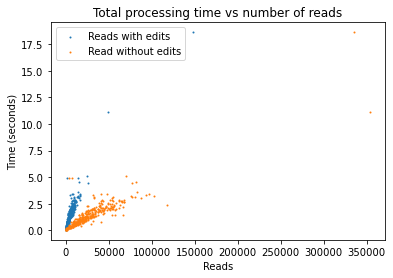

In [21]:
total_reads_and_times_df = total_reads_df.join(total_contig_times_df)

plt.scatter(total_reads_and_times_df.edited, total_reads_and_times_df.seconds, s=1)
plt.scatter(total_reads_and_times_df.no_edits, total_reads_and_times_df.seconds, s=1)

plt.title("Total processing time vs number of reads")
plt.ylabel("Time (seconds)")
plt.xlabel("Reads")
plt.legend(['Reads with edits', 'Read without edits'])

Text(0.5, 1.0, 'Runtime vs number of reads processed')

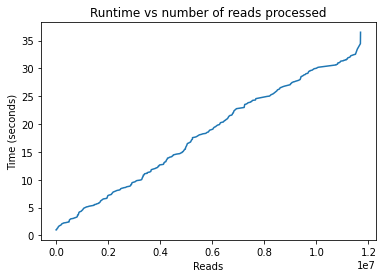

In [22]:
pd.DataFrame.from_dict(total_seconds_for_reads, orient='index').sort_index().plot(legend=False)
plt.xlabel("Reads")
plt.ylabel("Time (seconds)")
plt.title("Runtime vs number of reads processed")

In [23]:
rates = []
for reads, secs in zip(list(total_seconds_for_reads.keys()), list(total_seconds_for_reads.values())):
    rate = reads/secs
    rates.append(rate)

Average of 300224.2362724413 reads/second


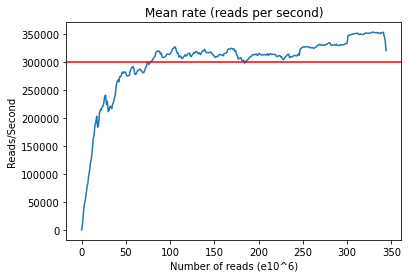

In [24]:
plt.plot(range(len(rates)), rates)
plt.title("Mean rate (reads per second)")
plt.ylabel("Reads/Second")
plt.xlabel("Number of reads (e10^6)")

average_rate = np.mean(rates)
plt.axhline(average_rate, color='r')
print("Average of {} reads/second".format(average_rate))

In [25]:
seconds_per_read = 1/average_rate

In [29]:
import math

reads_per_cell = 50000
total_cells = 15000
total_reads = reads_per_cell * total_cells
print(total_reads)

total_estimated_time = total_reads * seconds_per_read
print('Estimated total time in minutes for {} cells with {} reads per cell ({} total reads): {} minutes'.format(total_cells,
                                                                                               reads_per_cell,
                                                                                                                total_reads,
                                                                                               math.ceil(total_estimated_time/60), 3))


750000000
Estimated total time in minutes for 15000 cells with 50000 reads per cell (750000000 total reads): 42 minutes


# Second loop to get coverage at sites with edits

In [30]:
# Todo: get all edit info files for each contig and group them by contig, before processing.
# Todo: Multiprocess that too.

In [31]:
from glob import glob

splits = [i.split("/")[-1].split('_edit')[0] for i in glob('{}/edit_info/*'.format(output_folder))]
print("Accessing split bams: {}".format(', '.join(sorted(splits))))

Accessing split bams: 10_000_0_8168438, 10_001_8168438_16336876, 10_002_16336876_24505314, 10_003_24505314_32673752, 10_004_32673752_40842190, 10_005_40842190_49010628, 10_006_49010628_57179066, 10_007_57179066_65347504, 10_008_65347504_73515942, 10_009_73515942_81684380, 10_010_81684380_89852818, 10_011_89852818_98021256, 10_012_98021256_106189694, 10_013_106189694_114358132, 10_014_114358132_122526570, 10_015_122526570_130695008, 11_000_0_7630159, 11_001_7630159_15260318, 11_002_15260318_22890477, 11_003_22890477_30520636, 11_004_30520636_38150795, 11_005_38150795_45780954, 11_006_45780954_53411113, 11_007_53411113_61041272, 11_008_61041272_68671431, 11_009_68671431_76301590, 11_010_76301590_83931749, 11_011_83931749_91561908, 11_012_91561908_99192067, 11_013_99192067_106822226, 11_014_106822226_114452385, 11_015_114452385_122082544, 12_000_0_7508064, 12_001_7508064_15016128, 12_002_15016128_22524192, 12_003_22524192_30032256, 12_004_30032256_37540320, 12_005_37540320_45048384, 12_00

### Gather the edit information generated for each subcontig, and group by contig so we only have 1 edit information dataframe to process per contig

In [32]:
all_edit_info_for_barcodes = []

edit_info_grouped_per_contig = defaultdict(lambda:[])
edit_info_grouped_per_contig_combined = defaultdict(lambda:[])

num_splits = len(splits)
print("Grouping edit information outputs by contig...")
for i, split in enumerate(splits):
    if i%10 == 0:
        print("\t{}/{}...".format(i, num_splits))
    contig = split.split("_")[0]
    
    barcode_to_coverage_dict = defaultdict()    
    
    barcode_to_coverage_dict = defaultdict()
    edit_info_file = '{}/edit_info/{}_edit_info.tsv'.format(output_folder, split)
    edit_info = pd.read_csv(edit_info_file, sep='\t')
    edit_info_grouped_per_contig[contig].append(edit_info)
print("Done grouping! Concatenating ...")

for contig, list_of_edit_info_dfs in edit_info_grouped_per_contig.items():
    edit_info_grouped_per_contig_combined[contig] = pd.concat(list_of_edit_info_dfs)

print("Done concatenating!")

Grouping edit information outputs by contig...
	0/352...
	10/352...
	20/352...
	30/352...
	40/352...
	50/352...
	60/352...
	70/352...
	80/352...
	90/352...
	100/352...
	110/352...
	120/352...
	130/352...
	140/352...
	150/352...
	160/352...
	170/352...
	180/352...
	190/352...
	200/352...
	210/352...
	220/352...
	230/352...
	240/352...
	250/352...
	260/352...
	270/352...
	280/352...
	290/352...
	300/352...
	310/352...
	320/352...
	330/352...
	340/352...
	350/352...
Done grouping! Concatenating ...
Done concatenating!


### Get coverage at edit positions for each contig

In [33]:
import pandas as pd
pd.options.mode.chained_assignment = None 

def get_edit_info_for_barcode_in_contig(edit_info, contig, barcode, output_folder):
    
    bam_subfolder = "{}/split_bams/{}".format(output_folder, contig)
    barcode_bam = '{}/{}_{}.bam'.format(bam_subfolder, contig, barcode)

    samfile_for_barcode = pysam.AlignmentFile(barcode_bam, "rb")

    edit_info_for_barcode = edit_info[edit_info.barcode == barcode]
    positions_for_barcode = edit_info_for_barcode.position.tolist()

    coverage = []
    for pos in positions_for_barcode:
        coverage_at_pos = np.sum(samfile_for_barcode.count_coverage(contig, pos-1, pos, quality_threshold=0))
        coverage.append(coverage_at_pos)

    edit_info_for_barcode['coverage'] = coverage
    edit_info_for_barcode['contig'] = edit_info_for_barcode.contig.astype(str)

    return edit_info_for_barcode


def get_edit_info_for_barcode_in_contig_wrapper(parameters):
    edit_info, contig, barcode, output_folder = parameters
    edit_info_for_barcode = get_edit_info_for_barcode_in_contig(edit_info, contig, barcode, output_folder)
    return edit_info_for_barcode


def get_coverage_for_edits_in_contig(edit_info_grouped_per_contig_combined, output_folder):
    job_params = []
    
    for contig, edit_info in edit_info_grouped_per_contig_combined.items():
        unique_barcodes = sorted(edit_info.barcode.unique())

        for i, barcode in enumerate(unique_barcodes):                 
            job_params.append([edit_info, contig, barcode, output_folder])  
    return job_params
    
coverage_counting_job_params = get_coverage_for_edits_in_contig(edit_info_grouped_per_contig_combined, output_folder)

In [34]:
getsizeof(coverage_counting_job_params)

285392

In [35]:
start_time = time.perf_counter()

results = []
with Pool(processes=16) as p:
    max_ = len(coverage_counting_job_params)
    with tqdm(total=max_) as pbar:
        for _ in p.imap_unordered(get_edit_info_for_barcode_in_contig_wrapper, coverage_counting_job_params):
            pbar.update()
            results.append(_)
            
total_time = time.perf_counter() - start_time

100%|██████████| 32034/32034 [25:47<00:00, 20.70it/s]  


In [36]:
print(total_time)

1550.5566718876362


In [37]:
all_edit_info = pd.concat(results)

# Group by site to get final total edit and coverage counts at each site

# Verify C>T ratios

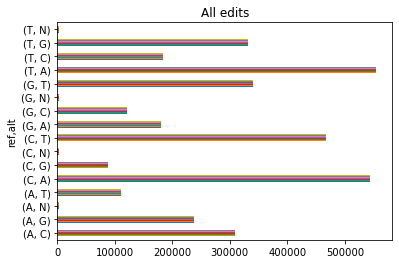

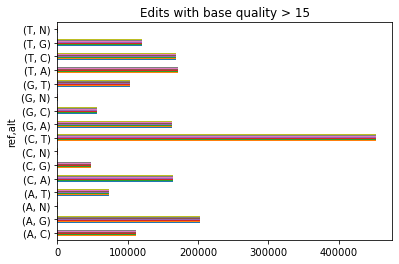

In [38]:
all_edit_info.groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
plt.title("All edits")

base_quality_thresh = 15
all_edit_info[all_edit_info.base_quality > base_quality_thresh].groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
plt.title("Edits with base quality > {}".format(base_quality_thresh))

all_edit_info_filtered = all_edit_info[all_edit_info.base_quality > base_quality_thresh]


In [39]:
example_new_ct =  all_edit_info_filtered[(all_edit_info_filtered.ref == 'C') & (all_edit_info_filtered.alt == 'T')].sort_values('position')

In [40]:
len(example_new_ct)

453805

In [41]:
example_new_ct

,barcode,contig,position,ref,alt,read_id,strand,dist_from_end,base_quality,mapping_quality,coverage
116,AACCACAGTCGTGATT-1,MT,2767,C,T,A01535:287:H3JJHDSX7:1:1446:13928:17284,+,17,37,255,1
89,AACAACCAGTAATACG-1,MT,2767,C,T,A01535:287:H3JJHDSX7:2:1273:15157:16094,+,17,37,255,8
134,AACGTCACAAGAATGT-1,MT,2785,C,T,A01535:287:H3JJHDSX7:1:2159:15483:16783,+,35,37,255,4
8,AAACCCACACCGTGGT-1,MT,2794,C,T,A01535:287:H3JJHDSX7:1:2352:3640:34287,+,27,37,255,10
176,AACCTGATCGCTCATC-1,MT,2802,C,T,A01535:287:H3JJHDSX7:2:1476:20745:1752,+,25,37,255,8
...,...,...,...,...,...,...,...,...,...,...,...
6801,AACGTCAAGCGAGGAG-1,1,194990129,C,T,A01535:287:H3JJHDSX7:1:1328:17092:35258,-,45,37,255,1
6839,AAAGGATCATGAAGCG-1,1,195036921,C,T,A01535:287:H3JJHDSX7:1:2307:26910:7639,-,30,37,255,1
6857,AAAGGGCCACCAGTTA-1,1,195047095,C,T,A01535:287:H3JJHDSX7:1:2602:27670:19820,-,39,37,255,1
6907,AAGACAAAGCCGGATA-1,1,195098756,C,T,A01535:287:H3JJHDSX7:1:1359:15429:5916,-,29,37,255,1


# Cells that do have STAMP expressed versus don't...?

In [42]:
stamp_expression_path = \
'/projects/ps-yeolab3/ekofman/Sammi/MouseBrainEF1A_SingleCell_EPR_combined/\
4.1_cells_with_middling_stamp/stamp_expression_for_all_used_cells.tsv'

In [43]:
stamp_expression_df = pd.read_csv(stamp_expression_path, sep='\t', index_col=0)

<AxesSubplot:>

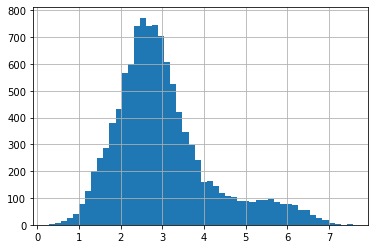

In [44]:
stamp_expression_df.Stamp.hist(bins=50)

In [50]:
all_edit_info_filtered['edit'] = all_edit_info_filtered['ref'] + '>' + all_edit_info_filtered['alt']

0
0.5
1
2
3
4
5
6
6.5
6.6


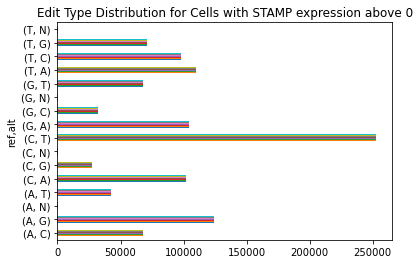

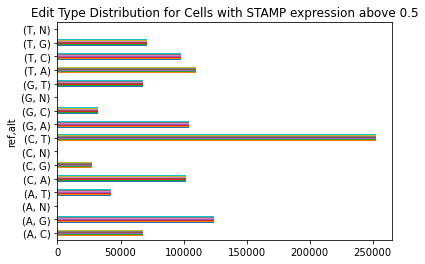

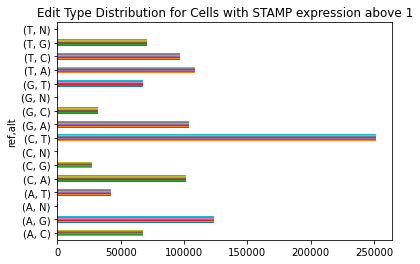

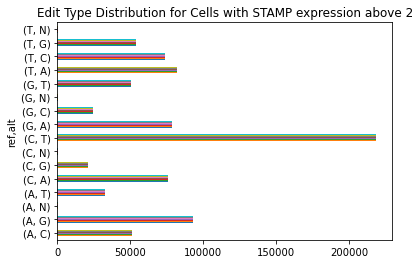

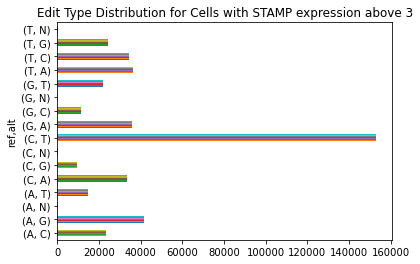

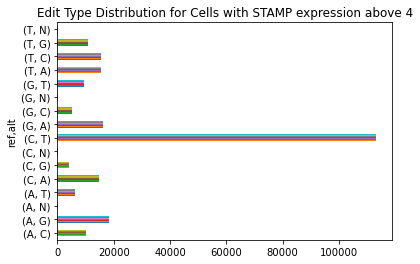

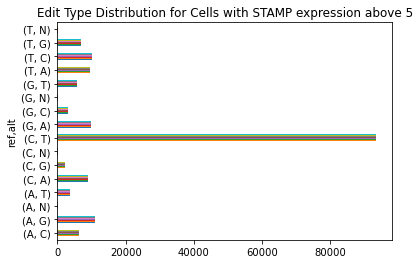

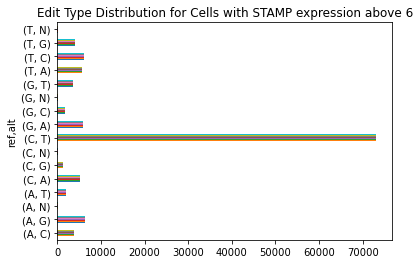

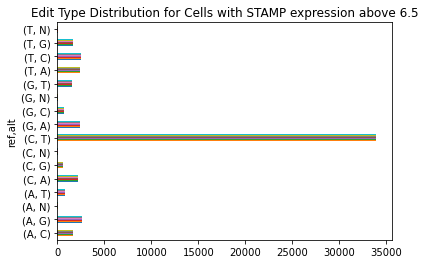

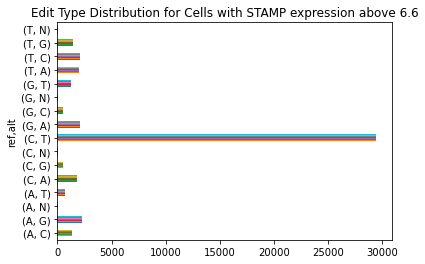

In [65]:
fractions_ct = []
threshs = [0, 0.5, 1, 2, 3, 4, 5, 6, 6.5, 6.6]
for thresh in threshs:
    print(thresh)
    barcodes_at_stamp_thresh = stamp_expression_df[stamp_expression_df.Stamp > thresh].index
    
    all_edit_info_filtered_in_stamp_level = all_edit_info_filtered[
        all_edit_info_filtered.barcode.isin(barcodes_at_stamp_thresh)]
    
    all_edit_info_filtered_in_stamp_level.groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
    plt.title("Edit Type Distribution for Cells with STAMP expression above {}".format(thresh))
    
    fraction_ct = len(all_edit_info_filtered_in_stamp_level[all_edit_info_filtered_in_stamp_level['edit'] == 'C>T'])/len(all_edit_info_filtered_in_stamp_level)
    fractions_ct.append(fraction_ct)
    
    

Text(0.5, 1.0, 'Enrichment for C>T edits within cells filtered by STAMP threshold')

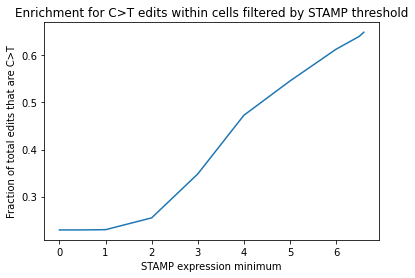

In [66]:
plt.plot(threshs, fractions_ct)
plt.ylabel("Fraction of total edits that are C>T")
plt.xlabel("STAMP expression minimum")
plt.title("Enrichment for C>T edits within cells filtered by STAMP threshold")

1
2
3
4
5
6
6.5
6.6


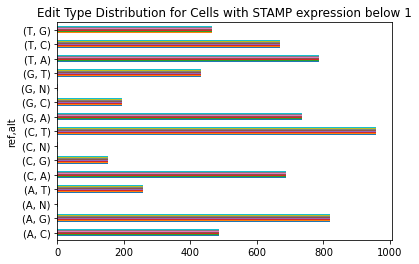

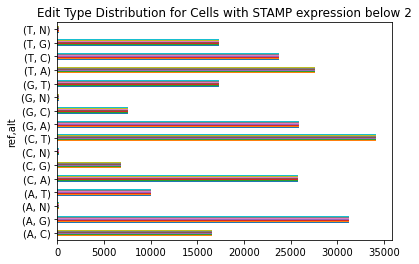

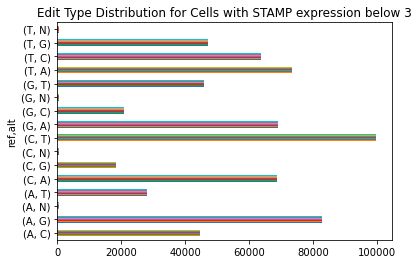

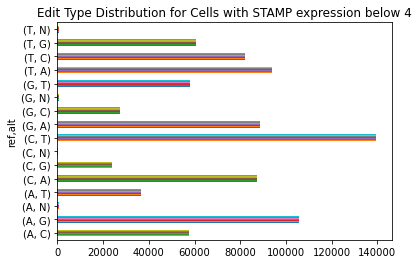

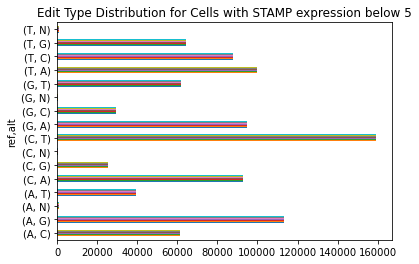

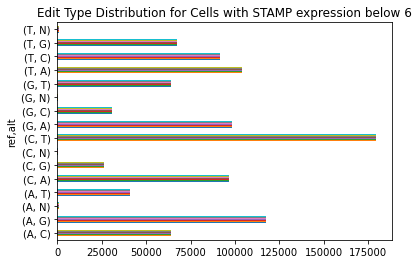

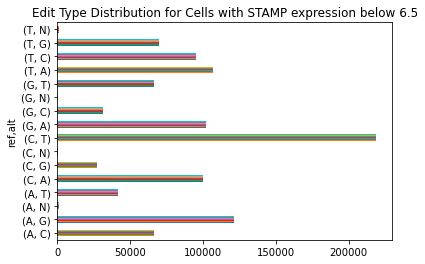

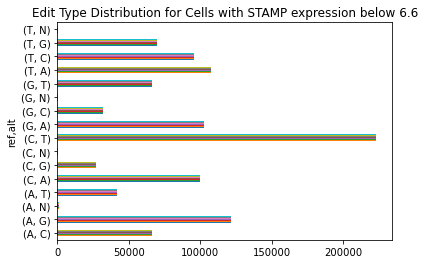

In [70]:
fractions_ct_low = []
threshs = [1, 2, 3, 4, 5, 6, 6.5, 6.6]
for thresh in threshs:
    print(thresh)
    barcodes_at_stamp_thresh = stamp_expression_df[stamp_expression_df.Stamp < thresh].index
    
    all_edit_info_filtered_in_stamp_level = all_edit_info_filtered[
        all_edit_info_filtered.barcode.isin(barcodes_at_stamp_thresh)]
    
    all_edit_info_filtered_in_stamp_level.groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
    plt.title("Edit Type Distribution for Cells with STAMP expression below {}".format(thresh))
    
    fraction_ct = len(all_edit_info_filtered_in_stamp_level[all_edit_info_filtered_in_stamp_level['edit'] == 'C>T'])/len(all_edit_info_filtered_in_stamp_level)
    fractions_ct_low.append(fraction_ct)

Text(0.5, 1.0, 'Enrichment for C>T edits within cells filtered by STAMP threshold')

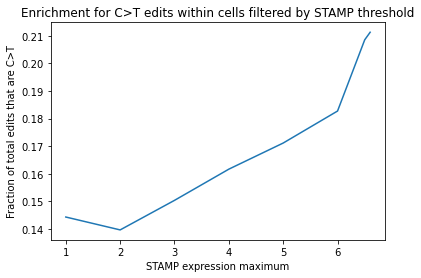

In [71]:
plt.plot(threshs, fractions_ct_low)
plt.ylabel("Fraction of total edits that are C>T")
plt.xlabel("STAMP expression maximum")
plt.title("Enrichment for C>T edits within cells filtered by STAMP threshold")